<a href="https://colab.research.google.com/github/vladevo6/URFU_my/blob/main/homework_momo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импортируем библиотеки

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Загружаем сами данные

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_clean.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


### Выводим всю информацию о DataFrame

In [ ]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32485 entries, 0 to 32484
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32485 non-null  object 
 1   Model                 32485 non-null  object 
 2   Year                  32485 non-null  int64  
 3   Style                 32485 non-null  object 
 4   Distance              32485 non-null  float64
 5   Engine_capacity(cm3)  32485 non-null  float64
 6   Fuel_type             32485 non-null  object 
 7   Transmission          32485 non-null  object 
 8   Price(euro)           32485 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 2.2+ MB


### Найдем дубликаты и удалим их, а также создадим заменятель редких значений, который будем использовать в пункте 3



In [ ]:
df.duplicated().sum()               #данной суммой узнаем сколько у нас дубликатов
DF = df.drop_duplicates()           #создаем новый DataFrame
DF = DF.reset_index(drop=True)      #обновляем индексы
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


In [ ]:
DF.duplicated().sum() #финальная проверка что дублей нет

0

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
qr = QuantileReplacer(threshold=0.01, )

qr.fit(DF[num_columns])

DF_num_rare = qr.transform(DF[num_columns])

In [ ]:
#Напишем заменятель редких категориальных данных
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [ ]:
#В этой реализации мы объединили обучение и применение через метод .fit_transform
rg = RareGrouper(threshold=0.001, other_value='rare')
DF_cat_rare = rg.fit_transform(DF[cat_columns])
DF_cat_rare

,Make,Model,Style,Fuel_type,Transmission
0,Toyota,Prius,Hatchback,Hybrid,Automatic
1,Renault,Grand Scenic,Universal,Diesel,Manual
2,Renault,Laguna,Universal,Diesel,Manual
3,Opel,Astra,Universal,Metan/Propan,Manual
4,Mercedes,Vito,Microvan,Diesel,Manual
...,...,...,...,...,...
32480,Volkswagen,Passat,Sedan,Petrol,Automatic
32481,Land Rover,Freelander,Crossover,Metan/Propan,Manual
32482,Dacia,Logan Mcv,Universal,Diesel,Manual
32483,Mazda,6,Combi,Diesel,Manual


### 1.  Выполните визуализацию данных с использованием библиотеки Seaborn:

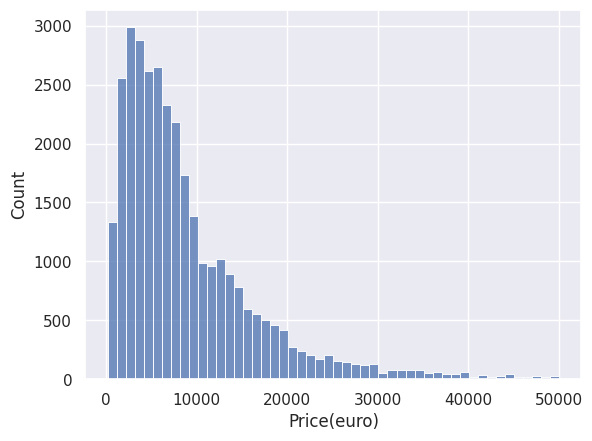

In [ ]:
#Гистограмма распределения цены (числовой признак)
sns.histplot(data=DF, x='Price(euro)', bins = 50);

<Axes: xlabel='Year', ylabel='Price(euro)'>

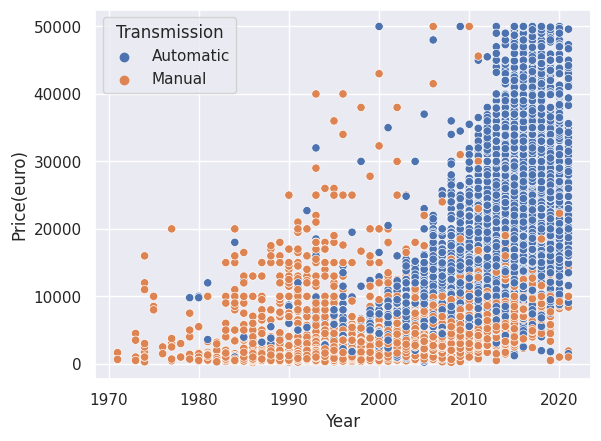

In [ ]:
# Скатерограмма для сравнения распределений года и цены по трансмиссии (категориальный признак)
sns.scatterplot(data=df, x='Year', y='Price(euro)', hue='Transmission')

<Axes: xlabel='Engine_capacity(cm3)', ylabel='Price(euro)'>

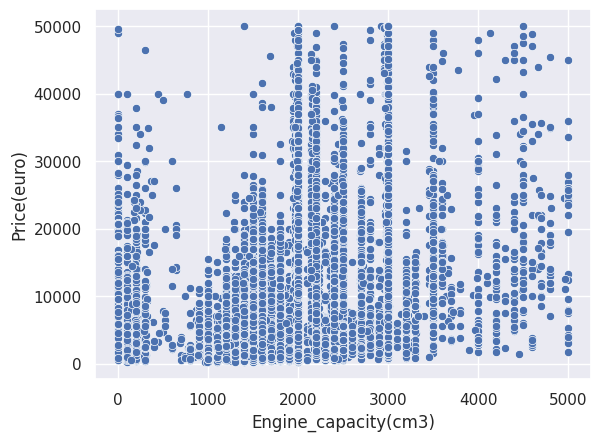

In [ ]:
# Скатерограмма для анализа созависимости цены и объема двигателя (числовые признаки)
sns.scatterplot(data=df, x='Engine_capacity(cm3)', y='Price(euro)')

Теперь делаем несколько выводов по проделанной работе:
1. На гистограмме распределения цены мы видим, что большинство автомобилей из выборки имеют цены в диапазоне от 2000 до 9000.
2. С помощью скатерограммы, которая сравнивает распределения года и цены по классам автомобилей, мы можем заметить, как различные трансмиссии автомобилей распределены по годам и ценам. Например, мы видим что в последние года идет преобладание автоматических коробок передач, а также автоматические намного дороже механических.
3. Вторая скатерограмма показывает нам связь между ценой и объемом двигателя.  Видно, что автомобили с большим объемом двигателя чаще имеют более высокие цены, но в диапазоне цен до 5000 имеется значительный разброс как для маленьких, так и для больших объемов двигателя.

Эти визуализации помогают нам получить представление о данных и лучше понять отношения между различными признаками. Они могут помочь нам в постановке гипотез о влиянии различных факторов на цену автомобилей и выборе наиболее важных признаков для дальнейшего анализа.



### 2. Выполните предварительную оценку признаков с  использованием библиотеки Pandas

1. Анализ числовых признаков с использованием методов describe, groupby, corr

In [ ]:
#Найдем какие колонки у нас численные, а какие категориальные и посчитаем их количество
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
 len =  5
numerical columns:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)'] 
 len =  4


In [ ]:
# Статистики числовых признаков
numeric_columns = ["Year", "Distance", "Engine_capacity(cm3)", "Price(euro)"]
numeric_stats = df[numeric_columns].describe()
numeric_stats

,Year,Distance,Engine_capacity(cm3),Price(euro)
count,32485.000000,32485.000000,32485.000000,32485.000000
mean,2008.222964,179214.511929,1834.547391,8962.558535
std,7.212853,91554.954674,625.236731,7839.471389
min,1971.000000,1.000000,0.000000,200.000000
25%,2004.000000,122000.000000,1497.000000,3500.000000
50%,2009.000000,180000.000000,1800.000000,6690.000000
75%,2014.000000,235000.000000,2000.000000,11999.000000
max,2021.000000,500000.000000,5000.000000,50000.000000


from matplotlib import pyplot as plt
numeric_stats['Year'].plot(kind='hist', bins=20, title='Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats['Distance'].plot(kind='hist', bins=20, title='Distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats['Engine_capacity(cm3)'].plot(kind='hist', bins=20, title='Engine_capacity(cm3)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats['Price(euro)'].plot(kind='hist', bins=20, title='Price(euro)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats.plot(kind='scatter', x='Year', y='Distance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats.plot(kind='scatter', x='Distance', y='Engine_capacity(cm3)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats.plot(kind='scatter', x='Engine_capacity(cm3)', y='Price(euro)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Distance']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = numeric_stats.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Distance')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Engine_capacity(cm3)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = numeric_stats.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Engine_capacity(cm3)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Price(euro)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = numeric_stats.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Price(euro)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = numeric_stats.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
numeric_stats['Year'].plot(kind='line', figsize=(8, 4), title='Year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats['Distance'].plot(kind='line', figsize=(8, 4), title='Distance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats['Engine_capacity(cm3)'].plot(kind='line', figsize=(8, 4), title='Engine_capacity(cm3)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
numeric_stats['Price(euro)'].plot(kind='line', figsize=(8, 4), title='Price(euro)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Сравнение статистик числовых признаков для разных классов
class_stats = df.groupby("Fuel_type")[numeric_columns].describe()
class_stats

Year                                                 \
                  count         mean       std     min     25%     50%   
Fuel_type                                                                
Diesel          15213.0  2009.537369  5.711487  1979.0  2006.0  2010.0   
Electric          241.0  2015.572614  3.408922  1990.0  2013.0  2016.0   
Hybrid           1829.0  2013.739202  3.155576  1986.0  2012.0  2014.0   
Metan/Propan     3537.0  2003.772123  6.825564  1977.0  1999.0  2005.0   
Petrol          11235.0  2006.525412  8.378293  1971.0  2001.0  2008.0   
Plug-in Hybrid    430.0  2015.102326  1.990360  2002.0  2014.0  2015.0   

                               Distance                 ...  \
                   75%     max    count           mean  ...   
Fuel_type                                               ...   
Diesel          2014.0  2021.0  15213.0  193755.046210  ...   
Electric        2018.0  2021.0    241.0   62743.219917  ...   
Hybrid          2016.0  2021.0   1829.0  140027.268999  ...   
Metan/Propan    2008.0  2021.0   3537.0  218733.640090  ...   
Petrol          2013.0  2021.0  11235.0  157727.998754  ...   
Plug-in Hybrid  2016.0  2020.0    430.0  133074.325581  ...   

               Engine_capacity(cm3)         Price(euro)                \
                                75%     max       count          mean   
Fuel_type                                                               
Diesel                       2200.0  5000.0     15213.0   9749.691514   
Electric                      100.0  4100.0       241.0  15254.419087   
Hybrid                       2500.0  4500.0      1829.0  14314.264625   
Metan/Propan                 2000.0  5000.0      3537.0   5169.263217   
Petrol                       2000.0  5000.0     11235.0   7754.003471   
Plug-in Hybrid               2000.0  4000.0       430.0  17603.811628   

                                                                          
                        std     min      25%      50%       75%      max  
Fuel_type                                                                 
Diesel          8059.930231   200.0   4500.0   7200.0  12700.00  50000.0  
Electric        9062.638358   600.0   8199.0  12199.0  21000.00  49600.0  
Hybrid          7478.195096   800.0   8999.0  12499.0  18199.00  49999.0  
Metan/Propan    4038.513111   300.0   2500.0   3950.0   6800.00  40000.0  
Petrol          7447.047497   250.0   2600.0   5500.0  10045.00  50000.0  
Plug-in Hybrid  9003.497238  2000.0  12292.5  13999.0  19461.75  49500.0  

[6 rows x 32 columns]

In [ ]:
# Корреляция между числовыми признаками
correlation = df[numeric_columns].corr()
correlation

,Year,Distance,Engine_capacity(cm3),Price(euro)
Year,1.000000,-0.390228,-0.056346,0.598019
Distance,-0.390228,1.000000,0.124329,-0.335888
Engine_capacity(cm3),-0.056346,0.124329,1.000000,0.321802
Price(euro),0.598019,-0.335888,0.321802,1.000000


2. Анализ категориальных признаков с использованием методов nunique, value_counts:

In [ ]:
# Количество уникальных категорий
categorical_columns = ["Make", "Model", "Style", "Fuel_type", "Transmission"]
unique_counts = df[categorical_columns].nunique()
unique_counts

Make             48
Model           781
Style            12
Fuel_type         6
Transmission      2
dtype: int64

In [ ]:
# Подсчет количества значений в каждой категории
value_counts = df[categorical_columns].value_counts()
value_counts

Make        Model        Style      Fuel_type     Transmission
Mercedes    E Class      Sedan      Diesel        Automatic       587
Renault     Megane       Universal  Diesel        Manual          453
BMW         5 Series     Sedan      Diesel        Automatic       384
Opel        Astra        Universal  Diesel        Manual          328
Nissan      Qashqai      Crossover  Diesel        Manual          293
                                                                 ... 
Rare        Eastar       Sedan      Petrol        Automatic         1
            Delta        Universal  Diesel        Manual            1
Hyundai     Matrix       Universal  Metan/Propan  Manual            1
Rare        Crosseastar  Crossover  Petrol        Automatic         1
Mitsubishi  Colt         Pickup     Hybrid        Manual            1
Length: 4548, dtype: int64

Выводы:
1. После того как мы нашли какие колонки у нас численные, а какие категориальные мы можем применять методы, которые позволяют получить полезную информацию о распределении, статистиках и связках между этими признаками.
2. Метод describe позволяет нам получать основыне статистики, такие как среднее/стандратное отклонение и тд. для числовых признаков. Это нам может помочь определить наличие аномальных значений или выбросов
3. Метод groupby позволяет сравить статистики числовых признаков для разных классов, например, можно сравнить среднюю цену по типам автомобилей или типу топлива/трансмиссии
4. Метод corr вычисляет корреляцию между числовыми признаками
5. Метод nunique позволяет считать количество уникальных категорий в категориальных признаках. Благодаря нему мы можем понять насколько разнообразны эти признаки
6. Метод value_counts считает количество значений в каждой категории категориальных признаков. Помогает выявить редкие или частые категории

### 3.Выполните предварительную обработку данных.  

In [ ]:
# Создаем pipeline для Distance
# Заменяем редкие значения и стандартизируем
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

In [ ]:
# Создаем pipeline для Engine_capacity(cm3)
# Просто Стандартизируем
num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

In [ ]:
# Создаем pipeline для Year и Price(euro)
# Заменяем степенное преобразование
num_pipe_year_price = Pipeline([
    ('power', PowerTransformer())
])

num_year_price = ['Year','Price(euro)']

In [ ]:
# Создаем pipeline для Transmission
# Достаточно порядкового кодирования
cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

In [ ]:
# Создаем pipeline для Style и Fuel_type
# Выполняем one-hot кодирование
cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

In [ ]:
# Создаем pipeline для Make
# Делаем замену редких (но с другим порогом) и one-hot кодирование
cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

In [ ]:
# Создаем pipeline для Distance
# Делаем замену редких и one-hot кодирование
cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

In [ ]:
#Объединяем в единый Трансформер Колонок Данных
preprocessors = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year_price', num_pipe_year_price, num_year_price),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])
preprocessors

ColumnTransformer(transformers=[('num_distance',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['Distance']),
                                ('num_engine',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Engine_capacity(cm3)']),
                                ('num_year_price',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['Year', 'Price(euro)']),
                                ('cat_transmissio...
                                ('cat_make',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.001)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make']),
                                ('cat_model',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.0001)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Model'])])

In [ ]:
#"Обучаем" стандартно через .fit()
preprocessors.fit(DF);

In [ ]:
#спускаемся на уровень трансформеров
preprocessors.transformers_

[('num_distance',
  Pipeline(steps=[('QuantReplace', QuantileReplacer(threshold=0.01)),
                  ('scaler', StandardScaler())]),
  ['Distance']),
 ('num_engine',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['Engine_capacity(cm3)']),
 ('num_year_price',
  Pipeline(steps=[('power', PowerTransformer())]),
  ['Year', 'Price(euro)']),
 ('cat_transmission',
  Pipeline(steps=[('encoder', OrdinalEncoder())]),
  ['Transmission']),
 ('cat_style_fuel',
  Pipeline(steps=[('encoder',
                   OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                                 sparse_output=False))]),
  ['Style', 'Fuel_type']),
 ('cat_make',
  Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.001)),
                  ('encoder',
                   OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                                 sparse_output=False))]),
  ['Make']),
 ('cat_model',
  Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.0001)),
       

In [ ]:
#выбираем нужный трансформер (с индексом 5)
preprocessors.transformers_[5]

('cat_make',
 Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.001)),
                 ('encoder',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                                sparse_output=False))]),
 ['Make'])

In [ ]:
#Берем Pipeline (индекс 1, под индексом 0 - название)
preprocessors.transformers_[5][0]

'cat_make'

In [ ]:
preprocessors.transformers_[5][1]

Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.001)),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

In [ ]:
#обращаемся к Pipeline "по имени" (потому что это уже не список, а словарь)
preprocessors.transformers_[5][1]['encoder']

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [ ]:
#применяем то же метод `.get_feature_names_out` что и раньше
preprocessors.transformers_[5][1]['encoder'].get_feature_names_out(cat_make)

array(['Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo',
       'Make_Dodge', 'Make_Fiat', 'Make_Ford', 'Make_Honda',
       'Make_Hyundai', 'Make_Infiniti', 'Make_Jaguar', 'Make_Jeep',
       'Make_KIA', 'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln',
       'Make_Mazda', 'Make_Mercedes', 'Make_Mini', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Opel', 'Make_Other', 'Make_Peugeot',
       'Make_Porsche', 'Make_Rare', 'Make_Renault', 'Make_Rover',
       'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Subaru',
       'Make_Suzuki', 'Make_Toyota', 'Make_Vaz', 'Make_Volkswagen',
       'Make_Volvo'], dtype=object)

In [ ]:
#Повторим это для всех категориальных признаков с one-hot кодированием
cat_style_fuel_names = preprocessors.transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)
cat_make_names =  preprocessors.transformers_[5][1]['encoder'].get_feature_names_out(cat_make)
cat_model_names =  preprocessors.transformers_[6][1]['encoder'].get_feature_names_out(cat_model)

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year_price,
                    cat_transmission,
                    cat_style_fuel_names,
                    cat_make_names,
                    cat_model_names])

In [ ]:
DF_transformed = preprocessors.transform(DF)
pd.DataFrame(DF_transformed, columns=columns)

,Distance,Engine_capacity(cm3),Year,Price(euro),Transmission,Style_Cabriolet,Style_Combi,Style_Coupe,Style_Crossover,Style_Hatchback,...,Model_ZOE,Model_Zafira,Model_i10,Model_i20,Model_i3,Model_i30,Model_i40,Model_iQ,Model_ix20,Model_ix35
0,0.132322,-0.055256,0.337261,0.180634,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.522452,-0.535081,0.822301,0.296374,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.795275,-0.535081,0.495283,-0.013909,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.186886,-0.375140,-0.401125,-0.532149,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.278176,0.584512,-1.183001,-0.702638,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32480,-1.035358,-0.055256,1.164504,0.655393,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32481,0.459709,-0.055256,-0.934177,-0.456188,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32482,-1.024445,-0.535081,0.991462,0.062383,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32483,2.042079,0.264628,-0.401125,-0.558533,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Мы определили несколько типов преобразователей для данных: один для числовых , который изпользует StandardScaler для стандартизации переменных, и один для категориальных, который применяет OneHotEncoder для преобразования категориальных переменных в числовой формат.

Поскольку мы проверяли распределение числовых признаков, то был применен PowerTransformer.

После применения этих трансформаций мы приступили к обучению модели машинного обучения

Предварительная обработка данных является важным этапом в анализе данных и моделировании, который позволяет нам подготовить данные для дальнейшего использования.

